In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import torch
from torch import nn
import torch.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset

### 1. Load data

In [39]:
df = pd.read_csv('AML.csv')
df.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


In [40]:
n_row, n_column = df.shape
n_row

6362620

### 2. Preprosessing and EDA

###### a. Nan and duplicate check

In [41]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Duplicate checked! No duplicate data.

###### b. Check categorical feature

In [42]:
droped_nameOrig = df['nameOrig']
droped_nameDest = df['nameDest']
droped_step = df['step']
droped_isFlaggedFraud = df['isFlaggedFraud']
df = df.drop(columns=['nameOrig', 'nameDest', 'step', 'isFlaggedFraud'])
df

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,PAYMENT,9839.64,170136.00,160296.36,0.00,0.00,0
1,PAYMENT,1864.28,21249.00,19384.72,0.00,0.00,0
2,TRANSFER,181.00,181.00,0.00,0.00,0.00,1
3,CASH_OUT,181.00,181.00,0.00,21182.00,0.00,1
4,PAYMENT,11668.14,41554.00,29885.86,0.00,0.00,0
...,...,...,...,...,...,...,...
6362615,CASH_OUT,339682.13,339682.13,0.00,0.00,339682.13,1
6362616,TRANSFER,6311409.28,6311409.28,0.00,0.00,0.00,1
6362617,CASH_OUT,6311409.28,6311409.28,0.00,68488.84,6379898.11,1
6362618,TRANSFER,850002.52,850002.52,0.00,0.00,0.00,1


###### c. one_hot_encoding

In [43]:
df_encoded = pd.get_dummies(df, columns=['type'], prefix='type')
df_encoded

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,9839.64,170136.00,160296.36,0.00,0.00,0,False,False,False,True,False
1,1864.28,21249.00,19384.72,0.00,0.00,0,False,False,False,True,False
2,181.00,181.00,0.00,0.00,0.00,1,False,False,False,False,True
3,181.00,181.00,0.00,21182.00,0.00,1,False,True,False,False,False
4,11668.14,41554.00,29885.86,0.00,0.00,0,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...
6362615,339682.13,339682.13,0.00,0.00,339682.13,1,False,True,False,False,False
6362616,6311409.28,6311409.28,0.00,0.00,0.00,1,False,False,False,False,True
6362617,6311409.28,6311409.28,0.00,68488.84,6379898.11,1,False,True,False,False,False
6362618,850002.52,850002.52,0.00,0.00,0.00,1,False,False,False,False,True


###### d. Class balance check

In [44]:
fraud_counts = df['isFraud'].value_counts()
labels = ['No fraud (0)', 'Is fraud (1)']
sizes = [fraud_counts[0], fraud_counts[1]]

In [45]:
fraud_counts

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [46]:
y = df_encoded['isFraud']
X = df_encoded.drop(columns=['isFraud'])

In [47]:
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

In [48]:
fraud_counts = y_resampled.value_counts()
labels = ['No fraud (0)', 'Is fraud (1)']
sizes = [fraud_counts[0], fraud_counts[1]]

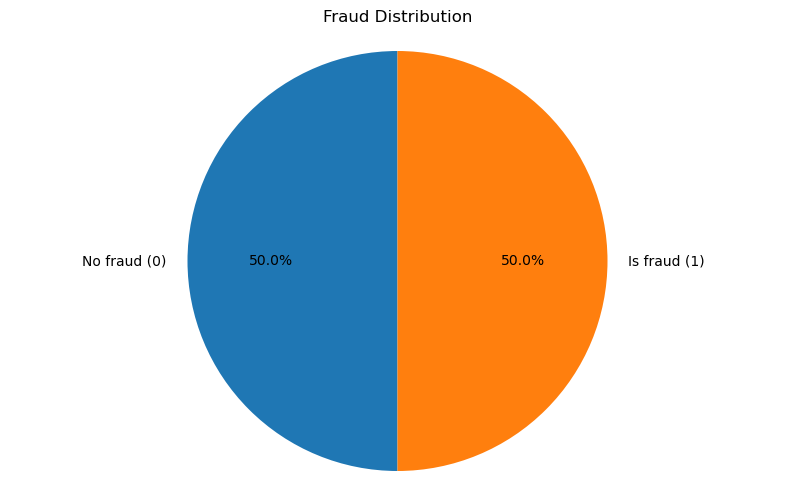

In [49]:
plt.figure(figsize=(10, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Fraud Distribution')
plt.axis('equal')
plt.show()

###### f. Correlation check 

In [50]:
corr_matrix = df_encoded.corr()

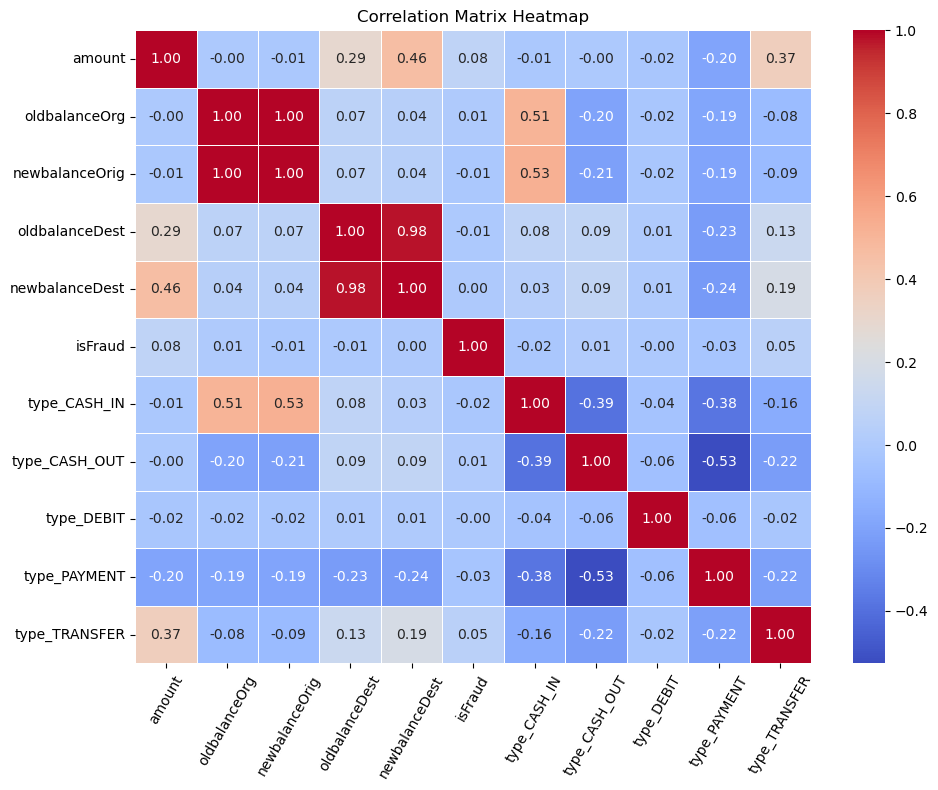

In [51]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.xticks(rotation=60)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

###### g. Feature important

In [52]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X_resampled)

In [53]:
df_x = pd.DataFrame(data=scaled_features)
df_y = pd.DataFrame(data=y_resampled).squeeze()

In [54]:
df_y.shape

(16426,)

In [55]:
rfc = RandomForestClassifier()
rfc.fit(df_x, df_y)

RandomForestClassifier()

In [56]:
importance = rfc.feature_importances_
feature_name = df_encoded.drop(columns=['isFraud']).columns

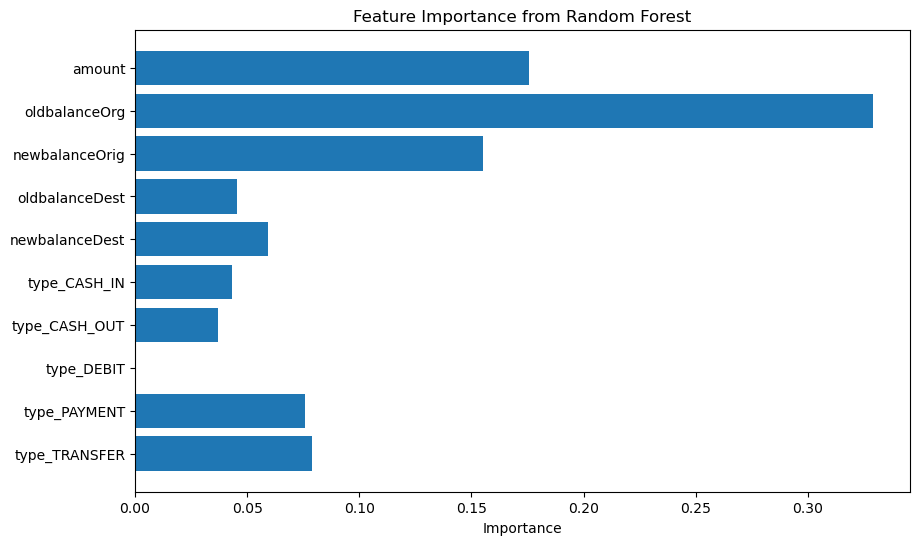

In [57]:
plt.figure(figsize=(10, 6))
plt.barh(feature_name, importance)
plt.xlabel("Importance")
plt.title("Feature Importance from Random Forest")
plt.gca().invert_yaxis()
plt.show()

###### h. Data visualization

In [58]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(df_x)

In [59]:
df_x.shape

(16426, 10)

In [60]:
def remove_extreme_pca(x_pca, threshold=3):
    mean = np.mean(x_pca, axis=0)
    std = np.std(x_pca, axis=0)
    lower_bound = mean - threshold * std
    upper_bound = mean + threshold * std
    
    mask = np.all((x_pca >= lower_bound) & (x_pca <= upper_bound), axis=1)
    return x_pca[mask], mask

In [61]:
reduced_cleaned, mask = remove_extreme_pca(reduced)

In [62]:
df_x_cleaned = df_x.iloc[mask]
df_y_cleaned = df_y.iloc[mask]

In [63]:
pca_df = pd.DataFrame(data=reduced_cleaned, columns=['PC1', 'PC2'])
pca_df['isFraud'] = df_y_cleaned.values

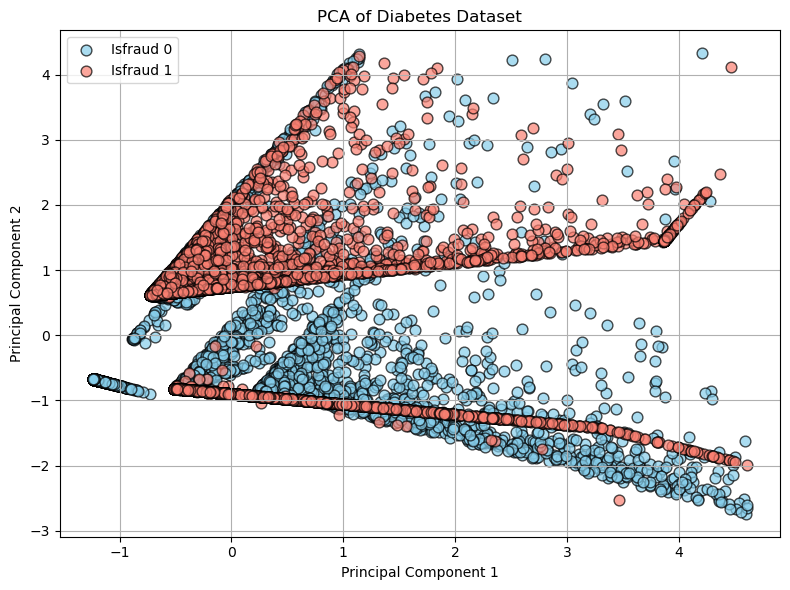

In [64]:
plt.figure(figsize=(8, 6))
colors = {0: 'skyblue', 1: 'salmon'}
for label in [0, 1]:
    subset = pca_df[pca_df['isFraud'] == label]
    plt.scatter(subset['PC1'], subset['PC2'], label=f'Isfraud {label}', 
                color=colors[label], alpha=0.7, edgecolor='k', s=60)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Diabetes Dataset')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Model

In [65]:
x_train, x_test, y_train, y_test = train_test_split(df_x_cleaned, df_y_cleaned, test_size=0.3, random_state=37)

In [66]:
input_row, input_column = x_train.shape


In [67]:
class nn_anti_money_laundering(nn.Module):
    def __init__(self, columns=input_column):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(columns, 256),
            nn.ReLU()
        )
        self.layer2 = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU()
        )
        self.layer3 = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.layer4 = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.out = nn.Linear(32, 1)
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.out(x)
        return x

In [68]:
n_epoch = 20
batch_size = 32
nn_AML = nn_anti_money_laundering()
criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(nn_AML.parameters(), lr = 0.001)

In [69]:
x_train_tensor = torch.tensor(x_train.values, dtype = torch.float32)
x_test_tensor = torch.tensor(x_test.values, dtype = torch.float32)

y_train_tensor = torch.tensor(y_train.values, dtype = torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype = torch.float32)

In [70]:
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [71]:
for i in range(n_epoch):
    total_loss = 0
    nn_AML.train()
    for inputs, labels in train_loader:
        outputs = nn_AML(inputs)
        loss = criterion(outputs.squeeze(1), labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss/len(train_loader)
    print(f'Epoch {i+1}/{n_epoch}  Loss: {avg_loss:.4f}')

Epoch 1/20  Loss: 0.2715
Epoch 2/20  Loss: 0.1973
Epoch 3/20  Loss: 0.1731
Epoch 4/20  Loss: 0.1467
Epoch 5/20  Loss: 0.1322
Epoch 6/20  Loss: 0.1212
Epoch 7/20  Loss: 0.1141
Epoch 8/20  Loss: 0.1092
Epoch 9/20  Loss: 0.1064
Epoch 10/20  Loss: 0.1000
Epoch 11/20  Loss: 0.1087
Epoch 12/20  Loss: 0.0992
Epoch 13/20  Loss: 0.0916
Epoch 14/20  Loss: 0.1047
Epoch 15/20  Loss: 0.0939
Epoch 16/20  Loss: 0.0983
Epoch 17/20  Loss: 0.0903
Epoch 18/20  Loss: 0.0937
Epoch 19/20  Loss: 0.0866
Epoch 20/20  Loss: 0.0922


In [72]:
nn_AML.eval()
t_loss = 0
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = nn_AML(inputs)
        loss = criterion(outputs.squeeze(1), labels)

        t_loss += loss.item()

        sigmoid = nn.Sigmoid()
        preds = sigmoid(outputs.squeeze(1))
        preds = (preds > 0.5).float()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [73]:
acc = accuracy_score(all_preds, all_labels)
acc

0.9307197676830533

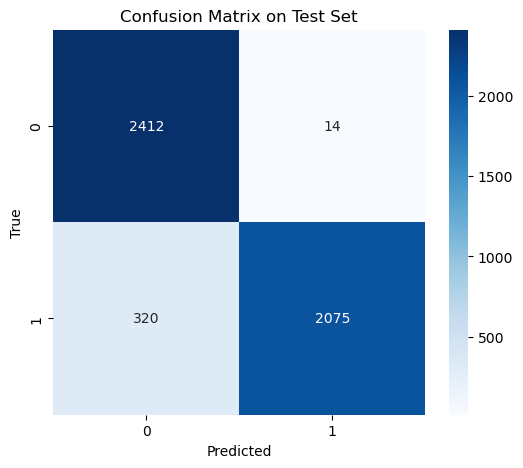

In [74]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Test Set')
plt.show()